In [1]:
from utils import rotation
import torch
import numpy as np
import copy
import matplotlib.pyplot as plt

In [8]:
path = '/home/avt/prediction/Waymo/data_processed/train1/4_5.pt'
scen = torch.load(path)

In [9]:
scen.keys()

dict_keys(['objects_of_interest', 'time_stamps', 'current_time_index', 'scenario_id', 'sdc_index', 'trajs_xyz', 'valid_masks', 'velocity_xy_heading', 'shapes', 'object_ids', 'object_types', 'track_to_predict_index', 'index', 'orig', 'theta', 'rot', 'feats', 'ctrs', 'gt_preds', 'has_preds', 'engage_id', 'engage_index', 'gt2_preds', 'road_info', 'graph'])

In [10]:
orig = scen['orig']
theta = scen['theta']
feats = copy.deepcopy(scen['feats'])
ctrs = scen['ctrs']
gt = scen['gt_preds']
gt2 = scen['gt2_preds']
has = scen['has_preds']

In [11]:
ctrs_plot = np.vstack(ctrs)

In [12]:
for i in range(len(feats)):
    feats[i] = np.cumsum(feats[i][:,:2], axis=0)
    feats[i] -= feats[i][-1]
    feats[i] += ctrs[i][:2]


In [13]:
trajs = scen['trajs_xyz']
masks = scen['valid_masks']

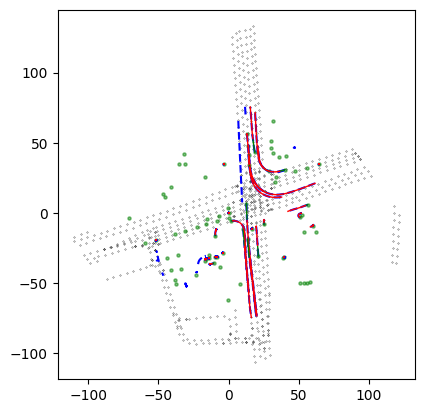

In [14]:
plt.scatter(scen['graph']['ctrs'].T[0] ,scen['graph']['ctrs'].T[1], c = 'black',s = 0.05)


for i in range(len(trajs)):
    tr = rotation(trajs[i], orig, theta)
    plt.plot(tr[masks[i]].T[0],tr[masks[i]].T[1], color = 'blue',linestyle='--')

for i in range(len(feats)):
    plt.plot(feats[i].T[0],feats[i].T[1], color ='green',linewidth = 1)
    plt.scatter(feats[i].T[0][0],feats[i].T[1][0], c = 'green',s = 5, alpha= 0.5)
    plt.plot(gt2[i][has[i]].T[0],gt2[i][has[i]].T[1],color = 'red',linewidth = 1)
    

plt.gca().set_aspect('equal')
plt.savefig('/home/avt/Desktop/' + 'tw1'+'.png',dpi=1200)

In [20]:
import torch
import numpy as np

In [152]:
scenlist = torch.load('sample_list.pt')

In [153]:
scenlist[0].keys()

dict_keys(['timestampsSeconds', 'tracks', 'scenarioId', 'sdcTrackIndex', 'dynamicMapStates', 'mapFeatures', 'currentTimeIndex', 'tracksToPredict'])

In [162]:
scenlist[0]['mapFeatures'][186]

{'id': '220',
 'lane': {'speedLimitMph': 15.0,
  'type': 'TYPE_SURFACE_STREET',
  'interpolating': True,
  'polyline': [{'x': 767.057786273894,
    'y': -658.6478170391671,
    'z': -7.03319378363487},
   {'x': 767.496840570243, 'y': -658.8544602492918, 'z': -7.034732245173332},
   {'x': 767.9363559256429, 'y': -659.060120527956, 'z': -7.036270706711791},
   {'x': 768.3768504769666, 'y': -659.2636737232533, 'z': -7.037809168250254},
   {'x': 768.8189683917954, 'y': -659.4636736524308, 'z': -7.0393476297887165},
   {'x': 769.2634394682837, 'y': -659.6583830488167, 'z': -7.040886091327176},
   {'x': 769.711030283569, 'y': -659.8458018014932, 'z': -7.042424552865638},
   {'x': 770.1624874795762, 'y': -660.0236938070383, 'z': -7.043963014404101},
   {'x': 770.6184743538399, 'y': -660.1896144182354, 'z': -7.045501475942563},
   {'x': 771.0795026376428, 'y': -660.3409409651584, 'z': -7.047039937481022},
   {'x': 771.5458620206832, 'y': -660.4749091103015, 'z': -7.048578399019485},
   {'x': 7

In [7]:
path = '/home/avt/prediction/Waymo/data_processed/train/0.pt'
zz = torch.load(path)

In [8]:
zz.keys()

dict_keys(['objects_of_interest', 'time_stamps', 'current_time_index', 'scenario_id', 'sdc_index', 'trajs_xyz', 'valid_masks', 'velocity_xy_heading', 'shapes', 'object_ids', 'object_types', 'track_to_predict_index', 'index', 'orig', 'theta', 'rot', 'feats', 'ctrs', 'gt_preds', 'has_preds', 'engage_id', 'engage_index', 'gt2_preds', 'road_info', 'graph'])

In [23]:
ttp = zz['track_to_predict_index']
types = np.array(zz['object_types'])
types[ttp]

array(['TYPE_CYCLIST', 'TYPE_VEHICLE', 'TYPE_VEHICLE'], dtype='<U15')

In [14]:
len(zz['object_types']), len(zz['object_ids']), len(zz['feats'])

(89, 89, 32)

In [21]:
ff = []
for i, mask in enumerate(masks):
    ff.append(mask[10])
np.array(ff).sum()



32

In [85]:
import numpy as np
from scipy import sparse
import copy
import torch
from utils import poly_gon_and_line,bboxes_overlapping,bboxes_of_poly, rotation
import matplotlib.pyplot as plt 

config = dict()
config['pred_range'] = [-100.0, 100.0, -100.0, 100.0]
config['num_scales'] = 6
config['cross_dist'] = 6
config['downsample_factor'] = 10

In [24]:
class Waymo_Motion_Preprocess_6:
    
    def __init__(self, scenario_list: list, config) -> None:
        """Initialization function for the class.

        Args:
            scenario_list: A list of scenarios.
            config: A dict for configuration.

        Note:
            scenario_list is directly parsed from the TFRecord by Waymo_Motion_Dataset_Loader.read_TFRecord.
        """

        self.counter: int = 0

        self.config: dict = config
        self.scenario_list: list = scenario_list
        self.current_scenario: dict = scenario_list[self.counter]

    
    def __getitem__(self, index: int) -> dict:
        """
        Args:
            index
        
        Notes:
            A scenario is a dict of 9 keys:

            'currentTimeIndex',
            'dynamicMapStates'
            'mapFeatures',
            'objectsOfInterest', 
            'scenarioId', 
            'sdcTrackIndex',
            'timestampsSeconds', 
            'tracks', 
            'tracksToPredict'

            get_road_info() and get_graph() are deployed for 'dynamicMapStates' and 'mapFeatures'
            
            get_obj_states() and get_obj_feats() are for the rest.

        """

        data = self.get_obj_states(index)
        data = self.get_obj_feats(data)

        data['road_info'] = self.get_road_info(index)
        data['graph'] = self.get_dsmp_graph(data)
        
        return data
    

    def __len__(self) -> int:
        """Get the number of scenarios in the list.

        Returns:
            Number of scenarios.
        """

        return len(self.scenario_list)
    

    def get_obj_states(self, index: int) -> dict:
        """Get the states of objects in a scenario corresponding to the given index.

        Args:
            index: index of scenario
        
        Returns:
            data: a dict with dict_keys(['index', 
                                        'objects_of_interest', 
                                        'time_stamps', 
                                        'current_time_index', 
                                        'scenario_id', 
                                        'sdc_index', 
                                        'trajs_xyz', 
                                        'valid_masks', 
                                        'velocity_xy_heading', 
                                        'shapes', 
                                        'object_ids', 
                                        'object_types', 
                                        'track_to_predict_index', 
                                        'track_to_predict_ids'])
        
        Notes:
            The 'objects_of_interest' is missing in a fair amount of scenarios, in which case dict['objects_of_interest'] = None.
            
            'sdc_index': index of Self-Driving Car.

        """

        scen = self.scenario_list[index]
        data = dict()

        data['scenario_id'] = scen['scenarioId']
        data['time_stamps'] = np.array(scen['timestampsSeconds'])
        data['current_time_index'] = scen['currentTimeIndex']
        data['sdc_index'] = scen['sdcTrackIndex']

        if 'objectsOfInterest' in scen.keys():
            data['objects_of_interest'] = scen['objectsOfInterest']
        else:
            data['objects_of_interest'] = None


        obj_id, obj_type, obj_valid,obj_traj,obj_velocity_heading,obj_shape = self.get_tracks_info(scen['tracks'])

        ttp_indx = [track['trackIndex'] for track in scen['tracksToPredict']]
        ttp_indx = np.array(ttp_indx)

        data['object_ids'] = obj_id
        data['object_types'] = obj_type
        data['trajs_xyz'] = obj_traj
        data['velocity_xy_heading'] = obj_velocity_heading
        data['shapes'] = obj_shape
        data['valid_masks'] = obj_valid

        data['target_indx'] = ttp_indx
        data['target_id'] = np.array(obj_id)[ttp_indx]
        data['target_type'] = np.array(obj_type)[ttp_indx]

        return data
    

    def get_obj_feats(self, data: dict) -> dict:

        orig = data['trajs_xyz'][data['sdc_index']][data['current_time_index']]
        pre_orig = data['trajs_xyz'][data['sdc_index']][data['current_time_index']-1]
        
        dir_vec = pre_orig - orig
        
        theta = np.pi - np.arctan2(dir_vec[1], dir_vec[0])
        rot = np.asarray([
                    [np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]], np.float32)

        data['orig'] = orig
        data['theta'] = theta
        data['rot'] = rot

        feats, ctrs, gt_preds, has_preds, engage_id, engage_indx = [], [], [], [], [], []
        
        for i in range(len(data['object_ids'])):

            feat = np.zeros((11, 4), np.float32)
            traj_xyz = data['trajs_xyz'][i][:11]

            mask_i = data['valid_masks'][i][:11] 

            if mask_i[-1] != True:
                continue
    
            reverse = list(np.flip(mask_i))
            if False in reverse:
                index = -reverse.index(False)
                
                traj_xyz = traj_xyz[index:,]

                feat[index:,:3] = rotation(traj_xyz, orig, theta)
                feat[index:,3] = 1.0

            else:
                index = 0
                feat[:,:3] = rotation(traj_xyz, orig, theta)
                feat[:,3] = 1.0

            mask_gt = np.arange(11,91)
            gt_pred = data['trajs_xyz'][i][mask_gt]

            has_pred = data['valid_masks'][i][mask_gt]

            ctrs.append(feat[-1, :3].copy())
            feat[1:, :3] -= feat[:-1, :3]
            feat[index, :3] = 0

            feats.append(feat) 
            engage_id.append(data['object_ids'][i])
            engage_indx.append(i)
            gt_preds.append(gt_pred)
            has_preds.append(has_pred)

        data['engage_id'] = engage_id
        data['engage_indx'] = engage_indx
        data['feats'] = feats
        data['ctrs'] = ctrs
        data['gt_preds'] = gt_preds 
        data['has_preds'] = has_preds

        target_indx_e = np.array([list(engage_id).index(id) for id in data['target_id']])
        data['target_indx_e'] = target_indx_e
       
        return data
    

    def get_road_info(self, index: int) -> dict:

        road_keys = dict()

        road_keys['driveway'] = ['polygon']
        road_keys['crosswalk'] = ['polygon']
        road_keys['speedBump'] = ['polygon']
        road_keys['stopSign'] = ['position', 'lane']
        road_keys['roadLine'] = ['polyline', 'type']
        road_keys['roadEdge'] = ['polyline', 'type']
        
        scen = self.scenario_list[index]
        map_feature = dict()

        for mf in scen['mapFeatures']:
            key = list(mf.keys())[1]
            if key in map_feature.keys():
                map_feature[key] += [mf]
            else:
                map_feature[key] = [mf]
        
        road_info = dict()
        for key in map_feature.keys():
            if key == 'lane':
                road_info[key] = road_info_lane(map_feature[key])     
            else:
                road_info[key] = road_info_except_lane(map_feature[key],road_keys)
        
        
        if 'roadEdge' in road_info.keys():
            copy_info = copy.deepcopy(road_info['roadEdge'])
            if 'roadLine' in road_info.keys():
                for key in copy_info.keys():
                    copy_info[key] += road_info['roadLine'][key]
            
        elif 'roadLine' in road_info.keys():
            copy_info = copy.deepcopy(road_info['roadLine'])
        
        else:
            copy_info = dict()
        
        road_info['road_Edge_and_Lines'] = copy_info


        dynamic = scen['dynamicMapStates']
        road_info['dynamic_map'] = get_dynamic_map(dynamic)
        
        return road_info
    

    def get_dsmp_graph(self, data: dict) -> dict:
        """
        get downsampled graph information.
        
        """

        engage_lanes = get_engage_lanes(data,self.config)
        ctrs, feats,node_idcs,num_nodes = get_nodes(engage_lanes,config)
        pre_pairs,suc_pairs, left_pairs, right_pairs = get_lane_pairs(engage_lanes)
        pre, suc, left, right, lane_idcs = get_node_pairs(engage_lanes,left_pairs,right_pairs)
       

        graph = dict()
        graph['ctrs'] = np.concatenate(ctrs, 0)
        graph['feats'] = np.concatenate(feats, 0)
        graph['num_nodes'] = num_nodes 
        graph['node_idcs'] = node_idcs

        graph['pre_pairs'] = pre_pairs   
        graph['suc_pairs'] = suc_pairs  
        graph['left_pairs'] = left_pairs  
        graph['right_pairs'] = right_pairs

        graph['pre'] = [pre]
        graph['suc'] = [suc]
        graph['left'] = left
        graph['right'] = right

        graph['lane_idcs'] = lane_idcs   

        for k1 in ['pre', 'suc']:
            for k2 in ['u', 'v']:
                graph[k1][0][k2] = np.asarray(graph[k1][0][k2], np.int64)

        for key in ['pre', 'suc']:
            graph[key] += dilated_nbrs(graph[key][0], graph['num_nodes'], self.config['num_scales'])

        return graph


    def get_tracks_info(self, tracks: list) -> list:
        """Transform the 'tracks' into a reader-friendly format. 
        
        Args:
            scenario_list[index]['tracks']
        
        Note:
            obj_velocity_heading: (v_x,v_y,heading)
        """
        
        obj_id, obj_type, obj_traj, obj_shape, obj_velocity_heading, obj_valid = [],[],[],[],[],[]
        
        for track in tracks:
            obj_id += [track['id']]
            obj_type += [track['objectType']]

            states = track['states']
            states_valid, states_traj, states_velocity_heading = [],[],[]
            
            for state in states:
                states_valid += [state['valid']]
                
                if state['valid']:
                    states_traj += [[state['centerX'],state['centerY'],state['centerZ']]]
                    states_velocity_heading += [[state['velocityX'],state['velocityY'],state['heading']]]
                else:
                    states_traj += [[0,0,0]]
                    states_velocity_heading += [[0,0,0]]
        
            if True in states_valid:
                valid_index = states_valid.index(True)
                valid_state = states[valid_index]
                states_shape = [valid_state['length'],valid_state['width'],valid_state['height']]
            else:
                states_shape = None
            
            obj_valid += [np.array(states_valid)]
            obj_traj += [np.array(states_traj)]
            obj_velocity_heading += [np.array(states_velocity_heading)]
            obj_shape += [np.array(states_shape)]

        return obj_id, obj_type, obj_valid,obj_traj,obj_velocity_heading,obj_shape


def road_info_except_lane(x_list, road_keys):

    output = {}
    output['id'] = []
    
    key_x = list(x_list[0].keys())[1]
    keys = road_keys[key_x]
    for key in keys:
        output[key] = []

    for x in x_list:
        output['id'] += [x['id']]
        for key in keys:
            if key in list(x[key_x].keys()):
                if key[0] == 'p':
                    output[key] += [poly_gon_and_line(x[key_x][key])]
                else:
                    output[key] += [x[key_x][key]]
            else:
                output[key] += [None]
    
    return output


def road_info_lane(x_dict):
    
    lanes = dict()

    for ln in x_dict:
        
        ln_info = dict()
        ln_id = ln['id']

        for key in ln['lane'].keys():
            if key[0] == 'p':
                ln_info[key] = poly_gon_and_line(ln['lane']['polyline'])
            else:
                ln_info[key] = ln['lane'][key]

        lanes[ln_id] = ln_info
    
    return lanes


def dilated_nbrs(nbr, num_nodes, num_scales):
    """
    Given the  adjacent matrix of distance=1,
    calculate the adjacent matrix of distance=2^i, i in range(1,num_scales)

    Args:
        nbr: dict(),
        graph['pre'] or graph['suc]

        num_nodes:  int, graph['num_nodes']

        num_scales:  int, config["num_scales"]

    Returns: a dict of adjacent matrix in coordinate form

    """

    data = np.ones(len(nbr['u']), np.bool)
    csr = sparse.csr_matrix((data, (nbr['u'], nbr['v'])), shape=(num_nodes, num_nodes))
    mat = csr
    nbrs = []
    
    for i in range(1, num_scales):
        mat = mat * mat
        nbr = dict()
        coo = mat.tocoo()   # converts a sparse matrix to coordinate format
        nbr['u'] = coo.row.astype(np.int64)
        nbr['v'] = coo.col.astype(np.int64)
        nbrs.append(nbr)

    return nbrs


def get_nodes(engage_lanes,config):

    ctrs, feats = [], []
    lane_ids = list(engage_lanes.keys())
    df = config['downsample_factor']

    for id in lane_ids:
        lane = engage_lanes[id]
        ctrln = lane['polyline']
        dsmp_ctrln = dsmp(ctrln, df)
        ctrs.append(np.asarray((dsmp_ctrln[:-1] + dsmp_ctrln[1:]) / 2.0, np.float32))
        feats.append(np.asarray(dsmp_ctrln[1:] - dsmp_ctrln[:-1], np.float32))
    
    node_idcs = []
    count = 0
    for i, ctr in enumerate(ctrs):
        node_idcs.append(range(count, count + len(ctr)))
        count += len(ctr)
    num_nodes = count
    
    return ctrs, feats, node_idcs, num_nodes


def dsmp(ctrln, df):

    if len(ctrln) <= df:
        df = len(ctrln) - 1

    return ctrln[::df]



def get_lane_pairs(engage_lanes):

    lane_ids = list(engage_lanes.keys())

    pre_pairs, suc_pairs, left_pairs, right_pairs = [], [], [], []

    for i, lane_id in enumerate(lane_ids):

        lane = engage_lanes[lane_id]

        if 'entryLanes' in lane.keys():
            for eL in lane['entryLanes']:
                if eL in lane_ids:
                    j = lane_ids.index(eL)
                    pre_pairs.append([i,j])
        
        if 'exitLanes' in lane.keys():
            for eL in lane['exitLanes']:
                if eL in lane_ids:
                    j = lane_ids.index(eL)
                    suc_pairs.append([i,j])
        
        if 'leftNeighbors' in lane.keys():
            neighbors = lane['leftNeighbors']
            for nn in neighbors:
                n_id = nn['featureId']
                j = lane_ids.index(n_id)
                pair = [i, j]
                left_pairs.append(pair)
        
        if 'rightNeighbors' in lane.keys():
            neighbors = lane['rightNeighbors']
            for nn in neighbors:
                n_id = nn['featureId']
                j = lane_ids.index(n_id)
                pair = [i, j]
                right_pairs.append(pair)

  
    pre_pairs = np.asarray(pre_pairs, np.int64)
    suc_pairs = np.asarray(suc_pairs, np.int64)
    left_pairs = np.asarray(left_pairs, np.int64)
    right_pairs = np.asarray(right_pairs, np.int64)  

    return pre_pairs,suc_pairs,left_pairs,right_pairs


def get_node_pairs(engage_lanes, left_pairs, right_pairs):
    lane_ids = list(engage_lanes.keys())

    ctrs, feats,node_idcs,num_nodes = get_nodes(engage_lanes,config)
    
    #---------------------------pre,suc-------------------------------#
    pre, suc = dict(), dict()
    
    for key in ['u', 'v']:
        pre[key], suc[key] = [], []
        
    for i, lane_id in enumerate(lane_ids):
        lane = engage_lanes[lane_id]
        idcs = node_idcs[i]

        pre['u'] += idcs[1:]
        pre['v'] += idcs[:-1]

        if 'entryLanes' in lane.keys():
            for eL in lane['entryLanes']:
                if eL in lane_ids:
                    j = lane_ids.index(eL)
                    pre['u'].append(idcs[0])
                    pre['v'].append(node_idcs[j][-1])

        suc['u'] += idcs[:-1]
        suc['v'] += idcs[1:]

        if 'exitLanes' in lane.keys():
            for eL in lane['exitLanes']:
                if eL in lane_ids:
                    j = lane_ids.index(eL)
                    suc['u'].append(idcs[-1])
                    suc['v'].append(node_idcs[j][0])
                
    #---------------------------left,right-------------------------------#
    left_u = np.unique(left_pairs[:,0])
    right_u = np.unique(right_pairs[:,0])

    left, right = dict(), dict()
    left['u'], left['v'], right['u'], right['v'] = [], [], [], []

    for p in left_u:

        ctrs_s = torch.tensor(ctrs[p])
        idcs_s = np.array(node_idcs[p])

        mask = left_pairs[:,0] == p
        left_v = left_pairs[:,1][mask]

        ctrs_n = torch.tensor(np.vstack([ctrs[i] for i in left_v]))
        idcs_n = []
        for i in left_v:
            idcs_n += list(node_idcs[i])
        idcs_n = np.array(idcs_n)

        dist = ctrs_s.unsqueeze(1) - ctrs_n.unsqueeze(0)
        dist = torch.sqrt((dist ** 2).sum(2))
        min_dist, min_idcs = dist.min(1)
        
        mask2 = min_dist < 4.9
        min_idcs = min_idcs[mask2.numpy()]

        left['u'] += list(idcs_s[mask2.numpy()])
        left['v'] += list(idcs_n[min_idcs.numpy()])

    for p in right_u:

        ctrs_s = torch.tensor(ctrs[p])
        idcs_s = np.array(node_idcs[p])

        mask = right_pairs[:,0] == p
        right_v = right_pairs[:,1][mask]

        ctrs_n = torch.tensor(np.vstack([ctrs[i] for i in right_v]))
        idcs_n = []
        for i in right_v:
            idcs_n += list(node_idcs[i])
        idcs_n = np.array(idcs_n)

        dist = ctrs_s.unsqueeze(1) - ctrs_n.unsqueeze(0)
        dist = torch.sqrt((dist ** 2).sum(2))
        min_dist, min_idcs = dist.min(1)
        
        mask2 = min_dist < 4.9
        min_idcs = min_idcs[mask2.numpy()]

        right['u'] += list(idcs_s[mask2.numpy()])
        right['v'] += list(idcs_n[min_idcs.numpy()])

    left['u'] = np.array(left['u'])
    left['v'] = np.array(left['v'])
    right['u'] = np.array(right['u'])
    right['v'] = np.array(right['v'])
    
    lane_idcs = []
    for i, idcs in enumerate(node_idcs):
        lane_idcs.append(i * np.ones(len(idcs), np.int64))

    lane_idcs = np.concatenate(lane_idcs, 0)
    
    return pre, suc, left, right, lane_idcs


def find_lane_ids_within_manhattan_range(lanes,origon,mht_range):
    """ 
    return the id of lanes within the manhattan range from the origon
    """
    mht_range = abs(mht_range)

    x_min = origon[0] - mht_range
    x_max = origon[0] + mht_range
    y_min = origon[1] - mht_range
    y_max = origon[1] + mht_range

    bbx_1 = [x_min,x_max,y_min,y_max]

    lane_id_list = []

    for key in lanes.keys():
        bbx_2 = bboxes_of_poly(lanes[key]['polyline'])
        if bboxes_overlapping(bbx_1,bbx_2):
            lane_id_list += [key]
    
    return lane_id_list


def get_engage_lanes(data,config):

    lanes = data['road_info']['lane']
    orig = data['orig']
    theta= data['theta']
    engage_lanes = dict()

    if 'manhattan' in config and config['manhattan']:
        x_min, x_max, y_min, y_max = config['pred_range']
        radius = max(abs(x_min), abs(x_max)) + max(abs(y_min), abs(y_max))
        lane_ids = find_lane_ids_within_manhattan_range(lanes,orig,radius)
        lane_ids = copy.deepcopy(lane_ids)
    
    else:
        lane_ids = list(lanes.keys())

    for id in lane_ids:
        lane = lanes[id]
        if len(lane['polyline']) < 2: #rule out those 1 point lane
            continue
        else:
            lane = copy.deepcopy(lane)
            polyline_xyz = rotation(lane['polyline'],orig,theta)
            lane['polyline'] = polyline_xyz
            engage_lanes[id] = lane
            
    return engage_lanes


def get_dynamic_map(dynamic):

    output = dict()
    
    for i,dd in enumerate(dynamic):
        if 'laneStates' in dd.keys():
            lane_states = dd['laneStates']
            for Ls in lane_states:
                lane_id = Ls['lane']
                if lane_id in output.keys():
                    output[lane_id]['time_step'] += [i]
                    output[lane_id]['state'] += [Ls['state']]
                else:
                    output[lane_id] = dict()
                    output[lane_id]['stop_point_xyz'] = poly_gon_and_line(Ls['stopPoint'])
                    output[lane_id]['time_step'] =[i]
                    output[lane_id]['state'] = [Ls['state']]
        else:
            continue
    
    return output if output.keys() else None



In [21]:
sample_list = torch.load('sample_list.pt')

In [22]:
sample_list[0]['tracksToPredict']

[{'trackIndex': 29, 'difficulty': 'LEVEL_1'},
 {'trackIndex': 16, 'difficulty': 'LEVEL_1'},
 {'trackIndex': 0, 'difficulty': 'LEVEL_2'}]

In [28]:
scen = Waymo_Motion_Preprocess_6(sample_list, config)
zz = scen[0]

/tmp/ipykernel_7672/3423127373.py:402: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.ones(len(nbr['u']), np.bool)


In [29]:
list(zz.keys())

['scenario_id',
 'time_stamps',
 'current_time_index',
 'sdc_index',
 'objects_of_interest',
 'object_ids',
 'object_types',
 'trajs_xyz',
 'velocity_xy_heading',
 'shapes',
 'valid_masks',
 'target_indx',
 'target_id',
 'target_type',
 'orig',
 'theta',
 'rot',
 'engage_id',
 'engage_indx',
 'feats',
 'ctrs',
 'gt_preds',
 'has_preds',
 'target_indx_e',
 'road_info',
 'graph']

In [73]:
zz['graph'].keys()

dict_keys(['ctrs', 'feats', 'num_nodes', 'node_idcs', 'pre_pairs', 'suc_pairs', 'left_pairs', 'right_pairs', 'pre', 'suc', 'left', 'right', 'lane_idcs'])

In [131]:
ctrs = zz['graph']['ctrs']
lane_idcs = zz['graph']['lane_idcs']

In [198]:
mask1 = np.logical_and(ctrs[:,0] < -100, ctrs[:,0] > -110)
mask2 = np.logical_and(ctrs[:,1]>-20, ctrs[:,1]<0)

In [199]:
mask = mask1 * mask2

In [200]:
lane_idcs[mask]

array([ 0,  0,  1,  1, 16, 16, 17, 17])

In [201]:
ctrs1 = ctrs[mask]

In [202]:
ctrs1

array([[-106.48389  ,  -11.27638  ,   -1.7031108],
       [-101.494705 ,  -11.228945 ,   -1.6637691],
       [-106.67064  ,   -8.175515 ,   -1.6305325],
       [-101.69496  ,   -8.112171 ,   -1.5997069],
       [-106.717636 ,   -4.3613424,   -1.6508229],
       [-101.744736 ,   -4.305921 ,   -1.6331758],
       [-106.709305 ,   -4.210115 ,   -1.6502968],
       [-101.73923  ,   -3.92678  ,   -1.6324106]], dtype=float32)

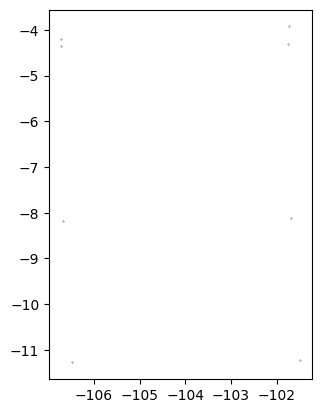

In [203]:
plt.scatter(ctrs1.T[0] ,ctrs1.T[1], c = 'black',s = 0.05)
plt.gca().set_aspect('equal')
plt.savefig('/home/avt/Desktop/' + 'tt2'+'.png',dpi=1200)
plt.show()

In [205]:
engage_lanes.keys()

dict_keys(['135', '136', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '155', '161', '168', '169', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '2

In [206]:
engage_lanes['135']

{'speedLimitMph': 0.0,
 'type': 'TYPE_BIKE_LANE',
 'interpolating': False,
 'polyline': array([[-113.96769244,  -11.34425261,   -1.76212324],
        [-113.46877085,  -11.33988102,   -1.75818908],
        [-112.96984943,  -11.3354893 ,   -1.75425492],
        [-112.47092819,  -11.33107755,   -1.75032075],
        [-111.97200712,  -11.32664588,   -1.74638659],
        [-111.47308623,  -11.32219439,   -1.74245243],
        [-110.97416552,  -11.31772318,   -1.73851826],
        [-110.47524498,  -11.31323236,   -1.7345841 ],
        [-109.97632461,  -11.30872204,   -1.73064994],
        [-109.47740442,  -11.30419233,   -1.72671577],
        [-108.97848441,  -11.29964331,   -1.72278161],
        [-108.47956457,  -11.29507512,   -1.71884745],
        [-107.9806449 ,  -11.29048784,   -1.71491328],
        [-107.48172541,  -11.28588158,   -1.71097912],
        [-106.9828061 ,  -11.28125645,   -1.70704496],
        [-106.48388695,  -11.27661255,   -1.70311079],
        [-105.98496798,  -11.2719

In [111]:
zz['graph']['lane_idcs']

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   2,   3,   4,   4,   5,
         5,   5,   5,   6,   7,   7,   8,   9,  10,  10,  11,  11,  12,
        13,  13,  13,  13,  13,  14,  15,  15,  15,  15,  15,  16,  16,
        16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
        17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  18,  18,
        18,  18,  18,  18,  18,  18,  18,  18,  19,  19,  19,  19,  19,
        19,  19,  19,  20,  20,  21,  21,  22,  22,  22,  22,  22,  22,
        22,  22,  22,  22,  22,  22,  22,  23,  23,  24,  24,  24,  25,
        25,  25,  25,  25,  25,  25,  26,  26,  27,  27,  27,  28,  28,
        29,  29,  30,  31,  31,  32,  32,  33,  33,  33,  33,  33,  33,
        33,  33,  33,  33,  34,  34,  34,  34,  34,  35,  35,  35,  35,
        35,  35,  35,  35,  35,  35,  36,  36,  36,  36,  36,  3

In [181]:
def pre_plot(data):

    ctrs = data['graph']['ctrs']
    left = data['graph']['left']
    right = data['graph']['right']
    pre = data['graph']['pre'][0]
    suc = data['graph']['suc'][0]
    plt.scatter(ctrs.T[0] ,ctrs.T[1], c = 'black',s = 0.05)

    fxs = [left,right,pre,suc]

    fx = left
    fx1 = suc

    for i in range(len(fx['u'])):
        p1 = ctrs[fx['u'][i]]
        p2 = ctrs[fx['v'][i]]
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]],color = 'skyblue', linewidth = 0.2)

    for i in range(len(fx1['u'])):
        p1 = ctrs[fx1['u'][i]]
        p2 = ctrs[fx1['v'][i]]
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]],color = 'red', linewidth = 0.2)

    # plt.plot(clx.T[0],clx.T[1],color='green')
    # plt.plot(clx1.T[0],clx1.T[1],color='brown')

    plt.gca().set_aspect('equal')
    plt.savefig('/home/avt/Desktop/' + 'tt1'+'.png',dpi=1200)
    plt.show()

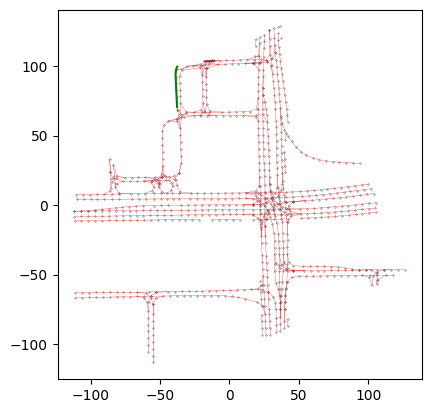

In [184]:
pre_plot(zz)

In [165]:
engage_lanes = get_engage_lanes(zz,config)

In [174]:
list(engage_lanes.keys())[220]

'398'

In [183]:
lanex = zz['road_info']['lane']['398']
lane1 = zz['road_info']['lane']['391']
lane2 = zz['road_info']['lane']['387']

orig = zz['orig']
theta = zz['theta']

clx = rotation(lanex['polyline'], orig, theta)
clx1 = rotation(lane1['polyline'], orig, theta)
clx2 = rotation(lane2['polyline'], orig, theta)

In [179]:
lanex

{'speedLimitMph': 15.0,
 'type': 'TYPE_SURFACE_STREET',
 'interpolating': False,
 'polyline': array([[ 822.69861735, -594.61942858,   -7.07296788],
        [ 822.28733037, -594.88853044,   -7.07496065],
        [ 821.89475075, -595.18426639,   -7.07695343],
        [ 821.52179938, -595.5044107 ,   -7.07894621],
        [ 821.16899125, -595.84663696,   -7.08093898],
        [ 820.83642894, -596.20857963,   -7.08293176],
        [ 820.52380742, -596.58788963,   -7.08492454],
        [ 820.23042846, -596.98228192,   -7.08691731],
        [ 819.95522282, -597.38957349,   -7.08891009],
        [ 819.696778  , -597.80771057,   -7.09090287],
        [ 819.45336983, -598.23478438,   -7.09289565],
        [ 819.22299616, -598.6690355 ,   -7.09488842],
        [ 819.00341119, -599.1088469 ,   -7.0968812 ],
        [ 818.79215972, -599.55272623,   -7.09887398],
        [ 818.58661078, -599.99927835,   -7.10086675],
        [ 818.38399064, -600.44716884,   -7.10285953],
        [ 818.179819  , -60

In [191]:
scenlist[0]['mapFeatures'][338]

{'id': '398',
 'lane': {'speedLimitMph': 15.0,
  'type': 'TYPE_SURFACE_STREET',
  'interpolating': False,
  'polyline': [{'x': 822.6986173516606,
    'y': -594.619428575674,
    'z': -7.072967875350978},
   {'x': 822.2873303724556, 'y': -594.8885304373676, 'z': -7.074960652411862},
   {'x': 821.8947507549692, 'y': -595.1842663940467, 'z': -7.076953429472747},
   {'x': 821.5217993754421, 'y': -595.5044106965731, 'z': -7.078946206533635},
   {'x': 821.1689912465905, 'y': -595.8466369589512, 'z': -7.080938983594519},
   {'x': 820.8364289396403, 'y': -596.2085796342266, 'z': -7.082931760655407},
   {'x': 820.523807420919, 'y': -596.587889627953, 'z': -7.084924537716292},
   {'x': 820.2304284647475, 'y': -596.9822819152798, 'z': -7.0869173147771765},
   {'x': 819.9552228194755, 'y': -597.3895734922025, 'z': -7.0889100918380645},
   {'x': 819.6967779952344, 'y': -597.8077105671896, 'z': -7.090902868898949},
   {'x': 819.4533698326395, 'y': -598.2347843788692, 'z': -7.092895645959837},
   {'x

In [193]:
scenlist[0]['mapFeatures'][333]

{'id': '391',
 'lane': {'speedLimitMph': 15.0,
  'type': 'TYPE_SURFACE_STREET',
  'interpolating': False,
  'polyline': [{'x': 848.2659881761577,
    'y': -602.83335102219,
    'z': -7.35319378363487},
   {'x': 847.8165371440358, 'y': -602.6332680529174, 'z': -7.346830147271232},
   {'x': 847.3669785090723, 'y': -602.4334269582971, 'z': -7.340466510907598},
   {'x': 846.9173329702189, 'y': -602.2337814673765, 'z': -7.3341028745439605},
   {'x': 846.4676211622583, 'y': -602.0342852879111, 'z': -7.327739238180323},
   {'x': 846.0178636721604, 'y': -601.834892113461, 'z': -7.321375601816689},
   {'x': 845.5680810529238, 'y': -601.6355556281239, 'z': -7.315011965453051},
   {'x': 845.1182938399317, 'y': -601.4362295112655, 'z': -7.308648329089417},
   {'x': 844.6685225585014, 'y': -601.2368674446172, 'z': -7.302284692725779},
   {'x': 844.2187877515657, 'y': -601.0374231185854, 'z': -7.2959210563621415},
   {'x': 843.769109978414, 'y': -600.8378502361935, 'z': -7.289557419998507},
   {'x':

In [196]:
scenlist[0]['mapFeatures'][329]

{'id': '387',
 'lane': {'speedLimitMph': 15.0,
  'type': 'TYPE_SURFACE_STREET',
  'interpolating': True,
  'polyline': [{'x': 839.6157032592783,
    'y': -606.8621144270317,
    'z': -7.3731937836348695},
   {'x': 839.8384246032139, 'y': -606.433218214859, 'z': -7.365574736015821},
   {'x': 840.0610234998467, 'y': -606.0042585276929, 'z': -7.357955688396773},
   {'x': 840.2813649953096, 'y': -605.5741366419502, 'z': -7.350336640777728},
   {'x': 840.4958682112283, 'y': -605.1410796842092, 'z': -7.34271759315868},
   {'x': 840.6997153398387, 'y': -604.702919144097, 'z': -7.335098545539632},
   {'x': 840.8870293836985, 'y': -604.2574626001789, 'z': -7.327479497920583},
   {'x': 841.0510501640917, 'y': -603.8029461304021, 'z': -7.319860450301535},
   {'x': 841.1843548602992, 'y': -603.3385345935569, 'z': -7.31224140268249},
   {'x': 841.2791751146193, 'y': -602.8648160522464, 'z': -7.304622355063442},
   {'x': 841.3278520393882, 'y': -602.3842150113326, 'z': -7.297003307444394},
   {'x': 